# 원리

* 음수를 포함하지 않는 행렬 X를 음수를 포함하지 않는 행렬 W와H의 곱으로 분해
> `X(n,m) = W(n,p) x H(p,m)` 에서 목적함수 `||X-WH||` 를 최소화

* PCA와 달리 특정방식으로 정렬되있지 않고 성분 개수를 줄이면 전체 성분이 바뀜

C:\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


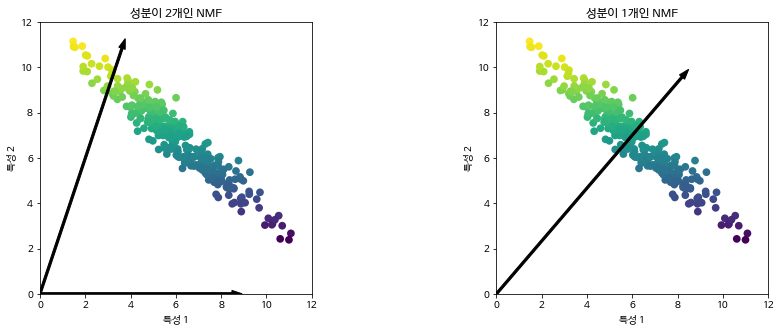

In [1]:
from ml1.preamble import*

mglearn.plots.plot_nmf_illustration()

# 얼굴 데이터에 적용

* 데이터 호출 및 전처리

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
X_people = people.data[mask]/255
y_people = people.target[mask]

X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)
image_shape = people.images[0].shape

* NMF 주성분 추출

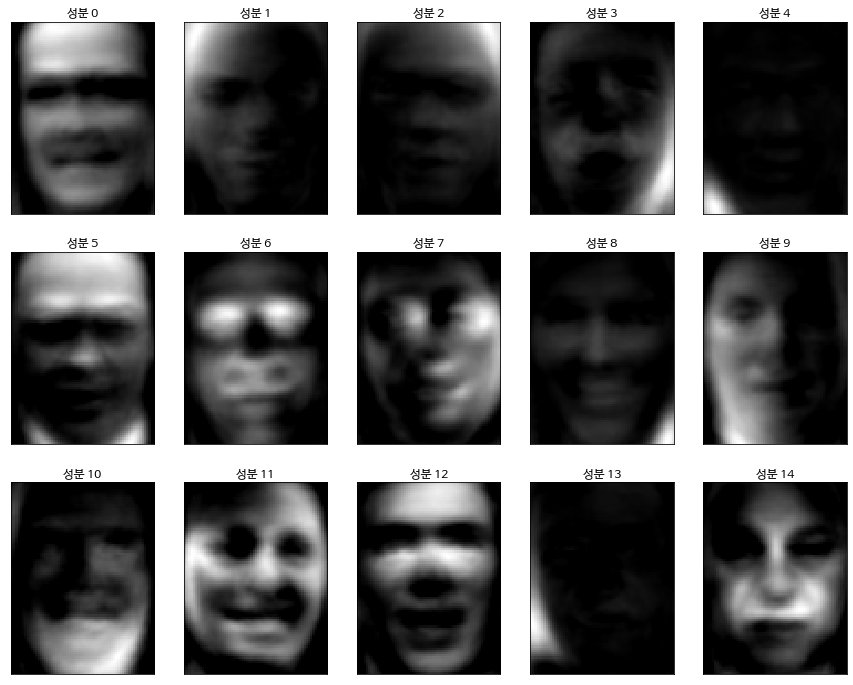

In [3]:
from sklearn.decomposition import NMF, PCA
nmf = NMF(n_components=15, random_state=0, max_iter=1000, tol=1e-2).fit(X_train)
X_train_nmf, X_test_nmf = nmf.transform(X_train), nmf.transform(X_test)

fig, axes = plt.subplots(3,5, figsize=(15,12), subplot_kw={'xticks':[], 'yticks':[]})
for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape), cmap='gray')
    ax.set_title(f'성분 {i}')

=> 성분3은 오른쪽으로 조금 돌아간 얼굴로 보이고 성분7은 왼쪽으로 조금 회전한 얼굴처럼 보임

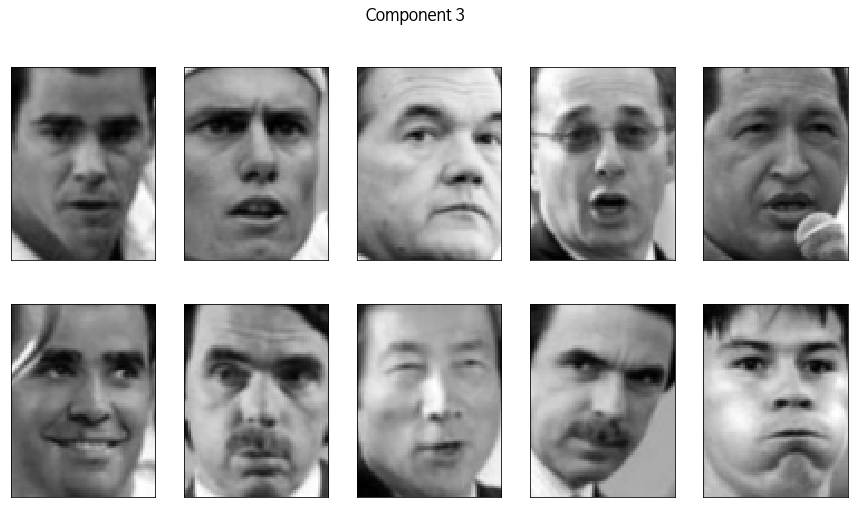

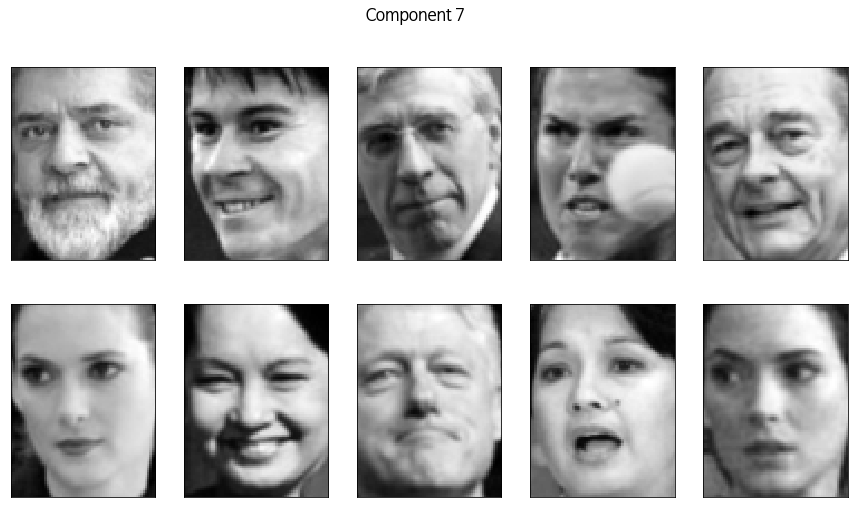

In [4]:
for compn in [3,7]:
    inds = np.argsort(X_train_nmf[:, compn])[::-1]
    fig, axes = plt.subplots(2,5, figsize=(15,8), subplot_kw={'xticks':[], 'yticks':[]})
    fig.suptitle(f'Component {compn}', fontsize=16)
    for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
        ax.imshow(X_train[ind].reshape(image_shape), cmap='gray')
    plt.show()

* 주성분을 이용한 얼굴 재구성

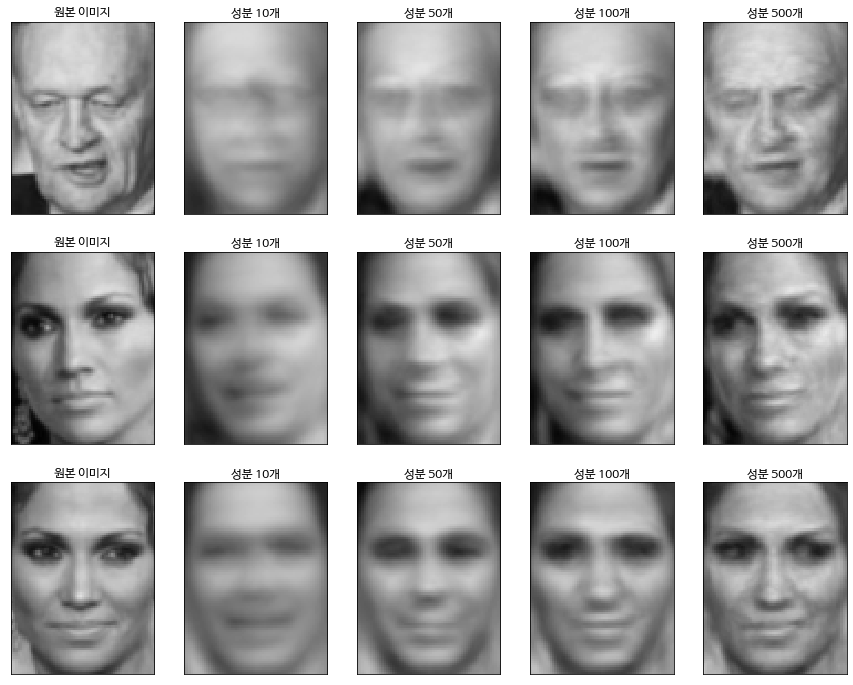

In [5]:
fix, axes = plt.subplots(3, 5, figsize=(15, 12), subplot_kw={'xticks': (), 'yticks': ()})

for im, ax in zip(X_test, axes[:,0]):
    ax.imshow(im.reshape(image_shape), cmap='gray', vmin=0, vmax=1)
    ax.set_title("원본 이미지")
for i, n_components in enumerate([10, 50, 100, 500]):
    nmf = NMF(n_components=n_components, max_iter=1000, tol=1e-2, random_state=0).fit(X_train)
    X_test_nmf = nmf.transform(X_test[:3])
    X_test_back = np.dot(X_test_nmf, nmf.components_)
    
    for im, ax in zip(X_test_back ,axes[:,1+i]):
        ax.imshow(im.reshape(image_shape), cmap='gray', vmin=0, vmax=1)
        ax.set_title(f'성분 {n_components}개')

=> PCA 보다 품질이 떨어짐 (PCA는 재구성 측면에서 최선)<br>
=> NMF는 주로 데이터에 있는 패턴을 찾는데 활용

# 신호 복원

In [6]:
# 3개의 원본 신호
S= mglearn.datasets.make_signals()

# 100개의 원본신호의 합
A = np.random.RandomState(0).uniform(size=(100,3))
X = np.dot(S, A.T)

# NMF 복원
nmf = NMF(n_components=3,max_iter=1000, tol=1e-2, random_state=42)
S_nmf = nmf.fit_transform(X)

# PCA 복원
pca = PCA(n_components=3)
S_pca = pca.fit_transform(X)

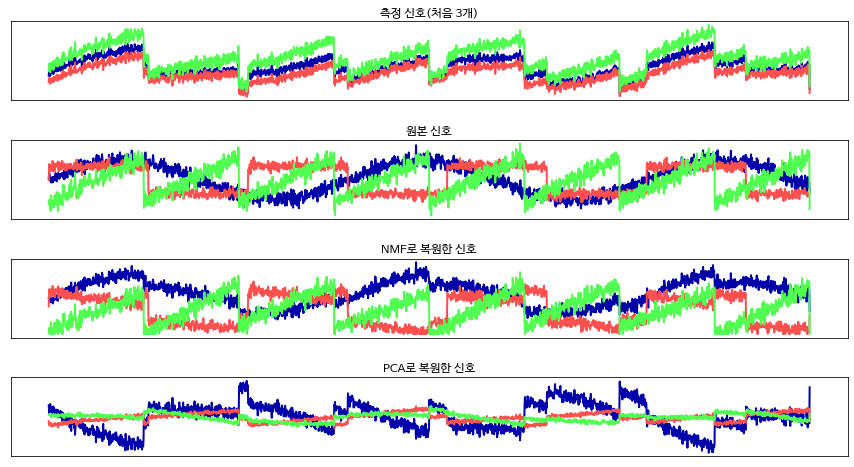

In [7]:
fig, axes = plt.subplots(4, figsize=(15,8), gridspec_kw={'hspace' : .5}, subplot_kw={'xticks':[], 'yticks':[]})
models = [X, S, S_nmf, S_pca]
names = ['측정 신호(처음 3개)', '원본 신호', 'NMF로 복원한 신호', 'PCA로 복원한 신호']
for model, name, ax in zip(models, names, axes):
    ax.set_title(name)
    ax.plot(model[:,:3],'-')

# 그 외 성분 추출 방법

* ICA : 독립 성분 분석
* FA : 요인 분석
* sparce coding(dictionary learning) : 희소코딩(딕셔너리 학습)